# Compare USDM & SPI
a. stein 4.18.2022

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


Load in USDM and SPI

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

# USDM will be already clipped, but we'll need to clip spi real quick
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')
spi_1y = xr.open_dataset(f'{dm_path}/spi/spi1y.nc')

In [3]:
usdm_da_wa = usdm['USDM'].rio.write_crs('EPSG:4326', inplace=True)
spi_da = spi_1y['spi'].rio.write_crs('EPSG:4326', inplace=True)

Grab some bounds for Washington and check the crs

In [4]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
wa_gdf = states_gdf[(states_gdf.NAME=='Washington')]

In [5]:
wa_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Clip SPI to WA

In [6]:
spi_da_wa = wrangle.clip_xarray(spi_da, wa_gdf)

In [7]:
spi_da_wa

<xarray.DataArray 'spi' (day: 3066, lat: 84, lon: 188)>
array([[[        nan,         nan,         nan, ..., -0.6199999 ,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.6199999 ,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -1.28      ,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.71000004,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.9000001 ,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -1.28      ,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.32000017,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.38999987,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.38999987,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 1980-01-05 1980-01-10 ... 2021-12-31
    crs      int64 0
Attributes:
    units:              
    description:        Standardized Precipitation Index
    long_name:          spi1y
    standard_name:      spi1y
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326

In [8]:
usdm_da_wa

<xarray.DataArray 'USDM' (date: 1163, lat: 139, lon: 314)>
[50760298 values with dtype=float64]
Coordinates:
  * lat          (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon          (lon) float64 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date         (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
    spatial_ref  int64 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -124.74590760646159 0.024999999999999963 0....

## Prelim plots

So I know that USDM is every week (7 days), while SPI is every 5 days.

In [9]:
# this is the first time stamp for UDSM ...
usdm_da_wa_sel = usdm_da_wa.sel(date='2000-01-04')

In [10]:
# and it looks like there is an SPI for the 5th, so that's
# close enough for me
spi_da_wa_sel = spi_da_wa.sel(day='2000-01-05')

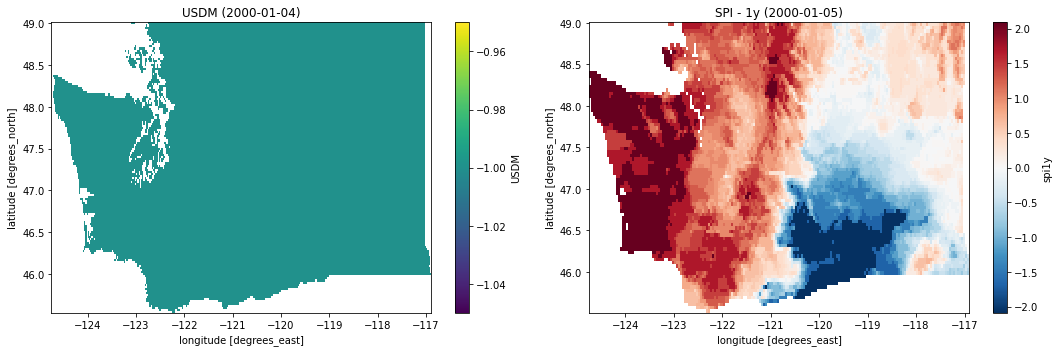

In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

usdm_da_wa_sel.plot(ax=ax[0])
spi_da_wa_sel.plot(ax=ax[1])

ax[0].set_title('USDM (2000-01-04)')
ax[1].set_title('SPI - 1y (2000-01-05)')

plt.tight_layout()

Hm, let's make a function to get the correct USDM colorbar ...

-1 : Neutral (or Wet)    
0 : D0 (Abnormal Dry)    
1 : D1 (Moderate Drought)    
2 : D2 (Severe Drought)    
3 : D3 (Extreme Drought)    
4 : D4 (Exceptional Drought)

In [12]:
usdm_colors=["white","yellow","navajowhite","orange","crimson","darkred"]
usdm_cmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", usdm_colors)
usdm_cats = ["D0","D1","D2","D3","D4"]

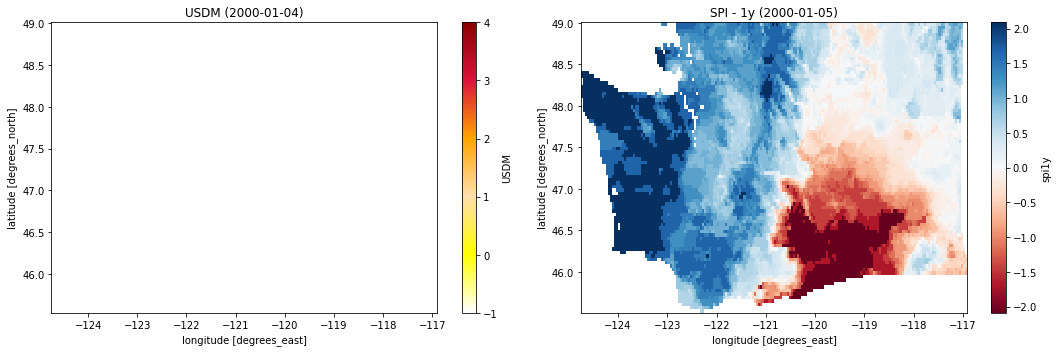

In [13]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

usdm_plot = usdm_da_wa_sel.plot(ax=ax[0], cmap = usdm_cmap, vmin=-1, vmax=4)
spi_da_wa_sel.plot(ax=ax[1], cmap='RdBu')

ax[0].set_title('USDM (2000-01-04)')
ax[1].set_title('SPI - 1y (2000-01-05)')

plt.tight_layout()

That works. It seems a bit tricky to get the proper labels, so I'm going to move on since it'll be useful to preserve those values for operations.

Here is the USDM's breakdown on values for SPI to create like-catagories: https://droughtmonitor.unl.edu/About/AbouttheData/DroughtClassification.aspx

D0 : -0.5 to -0.7 (21 to 30 p)    
D1 : -0.8 to -1.2 (11 to 20 p)    
D2 : -1.3 to -1.5 (6 to 10 p)    
D3 : -1.6 to -1.9 (3 to 5 p)    
D4 : -2.0 or less (0 to 2 p)

Which would then place the -1 marker to be anything greater than -0.5 I think ... yeah because USDM doesn't distinguish between degrees of wetness, so it'd all be the same.

Let's try implementing this ... and if it works then I'll toss it in a function

In [14]:
spi_1y_usdmcat = spi_da_wa_sel.copy()
# need to get the underlying array because I can't do this fancy
# indexing on the datarray (sad)
spi_1y_usdmcat_vals = spi_1y_usdmcat.values
# need to make a copy we don't edit to not compound reassignment
spi_1y_usdmcat_origin = spi_1y_usdmcat_vals.copy()
# set values ...
spi_1y_usdmcat_vals[spi_1y_usdmcat_origin > -0.5] = -1
spi_1y_usdmcat_vals[(spi_1y_usdmcat_origin <= -0.5)&(spi_1y_usdmcat_origin > -0.8)] = 0
spi_1y_usdmcat_vals[(spi_1y_usdmcat_origin <= -0.8)&(spi_1y_usdmcat_origin > -1.3)] = 1
spi_1y_usdmcat_vals[(spi_1y_usdmcat_origin <= -1.3)&(spi_1y_usdmcat_origin > -1.6)] = 2
spi_1y_usdmcat_vals[(spi_1y_usdmcat_origin <= -1.6)&(spi_1y_usdmcat_origin > -2.0)] = 3
spi_1y_usdmcat_vals[(spi_1y_usdmcat_origin <= -2.0)] = 4

In [15]:
spi_1y_usdmcat.loc[:,:] = spi_1y_usdmcat_vals

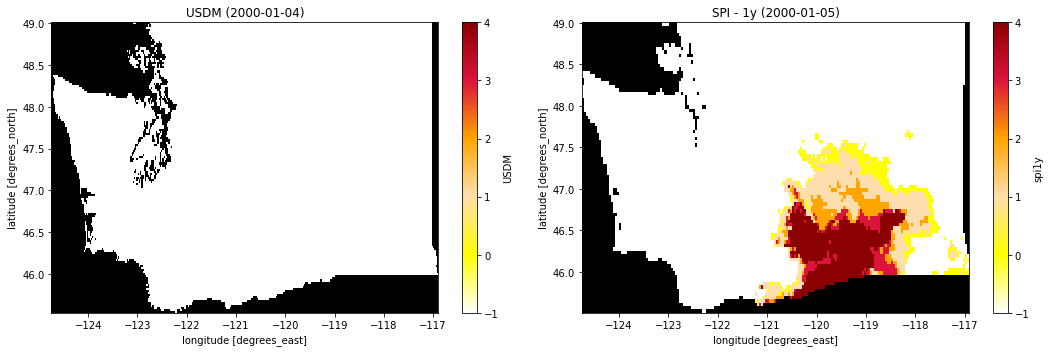

In [16]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

usdm_plot = usdm_da_wa_sel.plot(ax=ax[0], cmap = usdm_cmap, vmin=-1, vmax=4)
spi_1y_usdmcat.plot(ax=ax[1], cmap = usdm_cmap, vmin=-1, vmax=4)

ax[0].set_title('USDM (2000-01-04)')
ax[1].set_title('SPI - 1y (2000-01-05)')

# this will help make sure I'm not missing data ...
ax[0].set_facecolor('k')
ax[1].set_facecolor('k')

plt.tight_layout()

Ayyy, not too bad.

Let's get that in a function

In [17]:
def spi_to_usdmcat(spi_da:xr.DataArray):
    """Categorizes SPI based on USDM categories.

    Uses the mapping scheme presented by USDM (https://droughtmonitor.unl.edu/About/AbouttheData/DroughtClassification.aspx)
    Where Neutral is -1, D0 is 0, D1 is 1, D2, is 2, D3 is 3, and D4 is 4.

    Parameters
    ----------
    spi_da : xr.DataArray
        Contains SPI values.
    
    Returns
    -------
    xr.DataArray
        DataArray formatted the same as spi_da but using USDM categories.

    """

    # make sure we don't overwrite the original
    spi_da_copy = spi_da.copy()
    # can only do boolean indexing on the underlying array
    spi_da_vals = spi_da.values
    # get a copy to make sure reassignment isn't compounding
    spi_da_origin = spi_da_vals.copy()

    # assign neutral
    spi_da_vals[spi_da_origin > -0.5] = -1
    # assign D0
    spi_da_vals[(spi_da_origin <= -0.5)&(spi_da_origin > -0.8)] = 0
    # assign D1
    spi_da_vals[(spi_da_origin <= -0.8)&(spi_da_origin > -1.3)] = 1
    # assign D2
    spi_da_vals[(spi_da_origin <= -1.3)&(spi_da_origin > -1.6)] = 2
    # assign D3
    spi_da_vals[(spi_da_origin <= -1.6)&(spi_da_origin > -2.0)] = 3
    # assign D4
    spi_da_vals[(spi_da_origin <= -2.0)] = 4

    # put them back into the dataarray
    spi_da_copy.loc[:,:] = spi_da_vals

    return spi_da_copy

Test the function ...

In [18]:
spi_1y_cat = spi_to_usdmcat(spi_da_wa_sel)

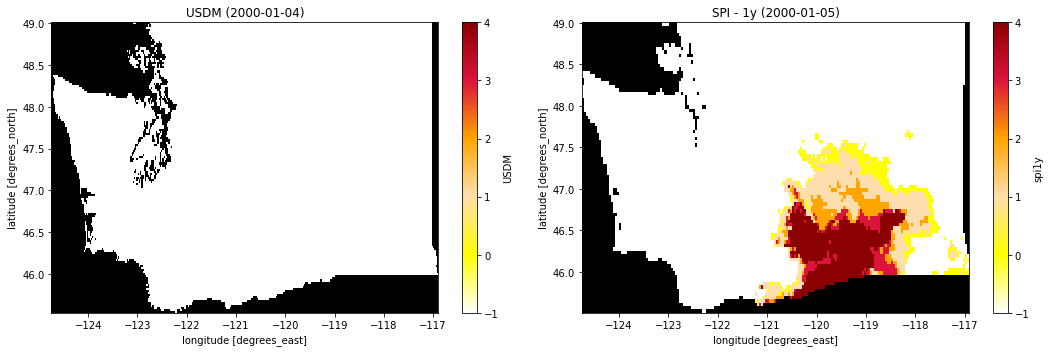

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

usdm_da_wa_sel.plot(ax=ax[0], cmap = usdm_cmap, vmin=-1, vmax=4)
spi_1y_cat.plot(ax=ax[1], cmap = usdm_cmap, vmin=-1, vmax=4)

ax[0].set_title('USDM (2000-01-04)')
ax[1].set_title('SPI - 1y (2000-01-05)')

# this will help make sure I'm not missing data ...
ax[0].set_facecolor('k')
ax[1].set_facecolor('k')

plt.tight_layout()

Great!

Now how do I compare them ... especially since they have different gridding ..

My main idea is to up-sample USDM ... but want to find a year that will show a bit more data ... let's go with the 2015 drought in WA

In [20]:
usdm_wa_2015 = usdm_da_wa.sel(date='2015-06-30')
spi_1y_wa_2015 = spi_to_usdmcat(spi_da_wa.sel(day='2015-06-29'))

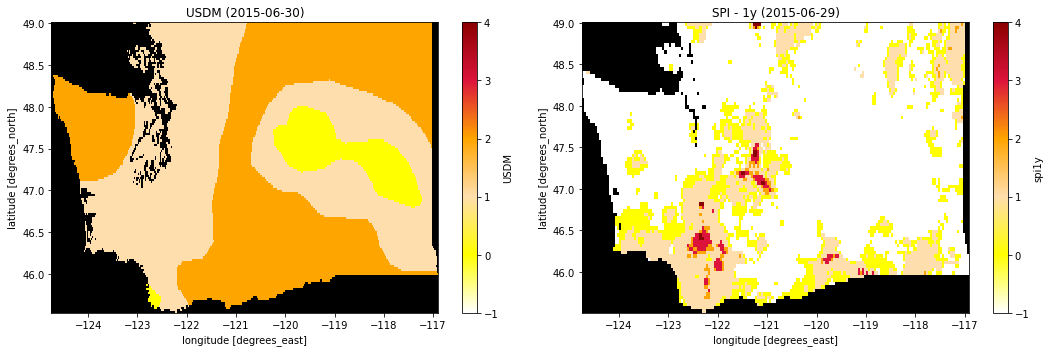

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

usdm_wa_2015.plot(ax=ax[0], cmap = usdm_cmap, vmin=-1, vmax=4)
spi_1y_wa_2015.plot(ax=ax[1], cmap = usdm_cmap, vmin=-1, vmax=4)

ax[0].set_title('USDM (2015-06-30)')
ax[1].set_title('SPI - 1y (2015-06-29)')

# this will help make sure I'm not missing data ...
ax[0].set_facecolor('k')
ax[1].set_facecolor('k')

plt.tight_layout()

Wow those are big differences. This'll be good to compare

Let's figure out how to compare things ... 

Ah, can use [rio.reproject_match](https://corteva.github.io/rioxarray/stable/examples/reproject_match.html)

In [22]:
usdm_wa_2015_resamp = usdm_wa_2015.rio.reproject_match(spi_1y_wa_2015)

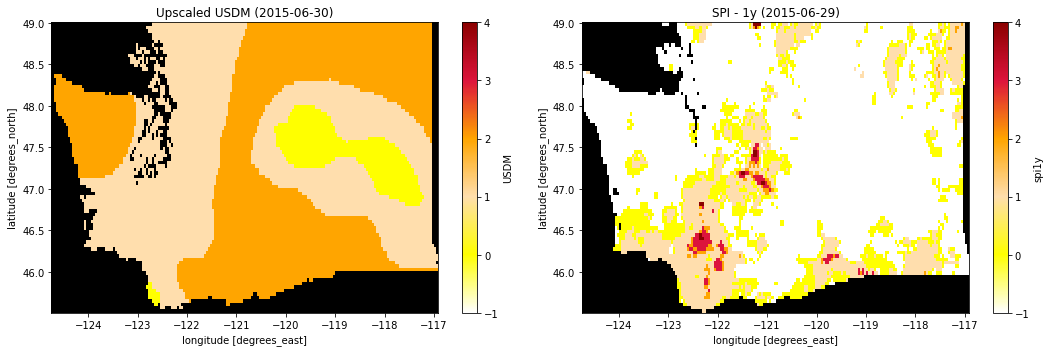

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

usdm_wa_2015_resamp.plot(ax=ax[0], cmap = usdm_cmap, vmin=-1, vmax=4)
spi_1y_wa_2015.plot(ax=ax[1], cmap = usdm_cmap, vmin=-1, vmax=4)

ax[0].set_title('Upscaled USDM (2015-06-30)')
ax[1].set_title('SPI - 1y (2015-06-29)')

# this will help make sure I'm not missing data ...
ax[0].set_facecolor('k')
ax[1].set_facecolor('k')

plt.tight_layout()

Okay, how does taking the difference look like? 

This will range from -5 to 5 ... where a positive number means that USDM has a higher category than SPI, a lower number means SPI has a higher category, and 0 means a match (besides nans).

In [24]:
usdm_wa_2015_resamp = usdm_wa_2015_resamp.rename({'x':'lon', 'y':'lat', 'date':'day'})

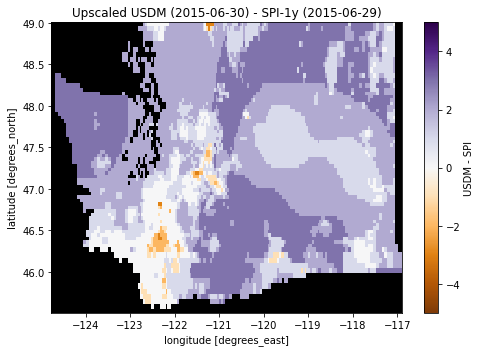

In [25]:
fig, ax = plt.subplots(figsize=(7,5))

(usdm_wa_2015_resamp - spi_1y_wa_2015).plot(ax=ax, vmin=-5, vmax=5, cmap='PuOr', cbar_kwargs={'label':'USDM - SPI'})
ax.set_facecolor('k')
ax.set_title('Upscaled USDM (2015-06-30) - SPI-1y (2015-06-29)')

plt.tight_layout()

So yeah, we are seeing where USDM puts WA in a drought that SPI largely does not ... but also see where SPI is more severe that popping up in contrast to USDM. Good to note that this is on the 5 to -5 scale, and not a 4 to -4 scale due to the -1's present in the dataset. I don't think adding them would be helpful since it'll hide the -1 differences more.

How does this look if I sample the other way?

In [26]:
spi_1y_wa_2015_resamp = spi_1y_wa_2015.rio.reproject_match(usdm_wa_2015)

In [27]:
spi_1y_wa_2015_resamp = spi_1y_wa_2015_resamp.rename({'x':'lon', 'y':'lat', 'day':'date'})

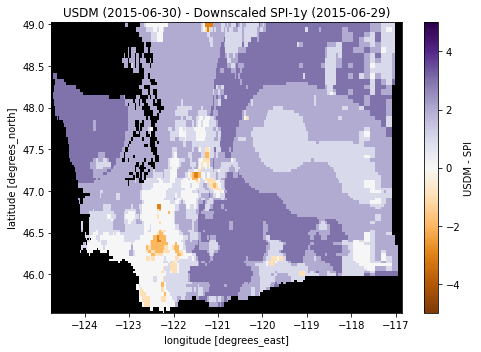

In [28]:
fig, ax = plt.subplots(figsize=(7,5))

(usdm_wa_2015 - spi_1y_wa_2015_resamp).plot(ax=ax, vmin=-5, vmax=5, cmap='PuOr', cbar_kwargs={'label':'USDM - SPI'})
ax.set_facecolor('k')
ax.set_title('USDM (2015-06-30) - Downscaled SPI-1y (2015-06-29)')

plt.tight_layout()

Looking pretty similar (beyond the obvious resolution difference) ... I'm not sure what is the more honest method to use here. I should get some other thoughts from the groups about this.

How do I compare more data ... cause I now have the spatial comparison, but I need it across time ... maybe animation ...

But even if I do that I need a way to sync times ...

So the USDM is made weekly, and the data cutoff is on Tuesday mornings ... so if SPI is Wed-Mon prio to the USDM date, then it is applicable, otherwise is goes into the next cycle.

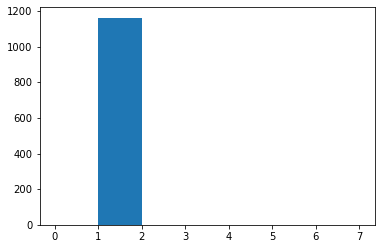

In [29]:
plt.hist(pd.to_datetime(usdm_da_wa['date']).day_of_week, bins=np.arange(0,8));

And I'm betting SPI should be fairly evenly spread out ...

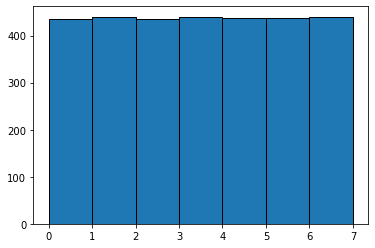

In [30]:
plt.hist(pd.to_datetime(spi_1y['day']).day_of_week, bins=np.arange(0,8), edgecolor='k');

Cool.

So I can probably do some grouping to align times ...but it'd def be a staggered animation. To not deal with that for now ... let's just grab what dates are closest to the USDM dates.

In [31]:
usdm_dates = pd.to_datetime(usdm['date'])
usdm_dates

DatetimeIndex(['2000-01-04', '2000-01-11', '2000-01-18', '2000-01-25',
               '2000-02-01', '2000-02-08', '2000-02-15', '2000-02-22',
               '2000-02-29', '2000-03-07',
               ...
               '2022-02-08', '2022-02-15', '2022-02-22', '2022-03-01',
               '2022-03-08', '2022-03-15', '2022-03-22', '2022-03-29',
               '2022-04-05', '2022-04-12'],
              dtype='datetime64[ns]', length=1163, freq=None)

In [32]:
spi_dates = pd.to_datetime(spi_da_wa['day'])
spi_dates

DatetimeIndex(['1980-01-05', '1980-01-10', '1980-01-15', '1980-01-20',
               '1980-01-25', '1980-01-30', '1980-02-04', '1980-02-09',
               '1980-02-14', '1980-02-19',
               ...
               '2021-11-16', '2021-11-21', '2021-11-26', '2021-12-01',
               '2021-12-06', '2021-12-11', '2021-12-16', '2021-12-21',
               '2021-12-26', '2021-12-31'],
              dtype='datetime64[ns]', length=3066, freq=None)

In [33]:
spi_dates = spi_dates[spi_dates >= '1999-12-31']
spi_dates

DatetimeIndex(['1999-12-31', '2000-01-05', '2000-01-10', '2000-01-15',
               '2000-01-20', '2000-01-25', '2000-01-30', '2000-02-04',
               '2000-02-09', '2000-02-14',
               ...
               '2021-11-16', '2021-11-21', '2021-11-26', '2021-12-01',
               '2021-12-06', '2021-12-11', '2021-12-16', '2021-12-21',
               '2021-12-26', '2021-12-31'],
              dtype='datetime64[ns]', length=1607, freq=None)

In [34]:
spi_dates_df = pd.DataFrame(spi_dates)
spi_dates_df['DoW'] = spi_dates.dayofweek
spi_dates_df.rename(columns={0:'SPI Date'}, inplace=True)
spi_dates_df

,SPI Date,DoW
0,1999-12-31,4
1,2000-01-05,2
2,2000-01-10,0
3,2000-01-15,5
4,2000-01-20,3
...,...,...
1602,2021-12-11,5
1603,2021-12-16,3
1604,2021-12-21,1
1605,2021-12-26,6


In [35]:
spi_dates_df['Days Till Tuesday'] = spi_dates_df['DoW']
dtt = {
    0:1,
    1:0,
    2:6,
    3:5,
    4:4,
    5:3,
    6:2
}
spi_dates_df['Days Till Tuesday'] = [dtt[day] for day in spi_dates_df['DoW'].values]
spi_dates_df

,SPI Date,DoW,Days Till Tuesday
0,1999-12-31,4,4
1,2000-01-05,2,6
2,2000-01-10,0,1
3,2000-01-15,5,3
4,2000-01-20,3,5
...,...,...,...
1602,2021-12-11,5,3
1603,2021-12-16,3,5
1604,2021-12-21,1,0
1605,2021-12-26,6,2


In [36]:
spi_dates_df['Pull for USDM'] = np.zeros(len(spi_dates_df))
spi_dates_df

,SPI Date,DoW,Days Till Tuesday,Pull for USDM
0,1999-12-31,4,4,0.0
1,2000-01-05,2,6,0.0
2,2000-01-10,0,1,0.0
3,2000-01-15,5,3,0.0
4,2000-01-20,3,5,0.0
...,...,...,...,...
1602,2021-12-11,5,3,0.0
1603,2021-12-16,3,5,0.0
1604,2021-12-21,1,0,0.0
1605,2021-12-26,6,2,0.0


In [37]:
last_valid_dow = 7

dtt_all = spi_dates_df['Days Till Tuesday'].values

for i, dtt_i in enumerate(dtt_all):
    if i < len(spi_dates_df)-1:
        if dtt_i < dtt_all[i+1]:
            spi_dates_df['Pull for USDM'].iloc[i] = 1

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [38]:
spi_dates_df[spi_dates_df['Pull for USDM'] == 1]

,SPI Date,DoW,Days Till Tuesday,Pull for USDM
0,1999-12-31,4,4,1.0
2,2000-01-10,0,1,1.0
3,2000-01-15,5,3,1.0
5,2000-01-25,1,0,1.0
6,2000-01-30,6,2,1.0
...,...,...,...,...
1599,2021-11-26,4,4,1.0
1601,2021-12-06,0,1,1.0
1602,2021-12-11,5,3,1.0
1604,2021-12-21,1,0,1.0


In [39]:
usdm_dates = usdm_dates[usdm_dates < '2022']

In [40]:
spi_dates_df_filtered = spi_dates_df[spi_dates_df['Pull for USDM'] == 1]
spi_dates_df_filtered['USDM Date'] = usdm_dates

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
spi_dates_df_filtered

,SPI Date,DoW,Days Till Tuesday,Pull for USDM,USDM Date
0,1999-12-31,4,4,1.0,2000-01-04
2,2000-01-10,0,1,1.0,2000-01-11
3,2000-01-15,5,3,1.0,2000-01-18
5,2000-01-25,1,0,1.0,2000-01-25
6,2000-01-30,6,2,1.0,2000-02-01
...,...,...,...,...,...
1599,2021-11-26,4,4,1.0,2021-11-30
1601,2021-12-06,0,1,1.0,2021-12-07
1602,2021-12-11,5,3,1.0,2021-12-14
1604,2021-12-21,1,0,1.0,2021-12-21


Ah-ha! There is our groupings. That totally wasn't a headache.

In [42]:
usdm_resampled = usdm_da_wa.rio.reproject_match(spi_1y_wa_2015)

In [43]:
usdm_resample_sel = usdm_resampled.sel(date=spi_dates_df_filtered['USDM Date'].values)
usdm_resample_sel = usdm_resample_sel.rename({'y':'lat', 'x':'lon'})

In [44]:
spi_sel = spi_da_wa.sel(day=spi_dates_df_filtered['SPI Date'].values)

Hm. I need a way to do the USDM categories for SPI across a dataset that includes time ... let's make a helper function.

In [45]:
def spi_to_usdmcat_multtime(spi_ds:xr.Dataset):
    """Categorizes SPI based on USDM categories for multiple times.
    
    See spi_to_usdmcat for further documentation.
    
    Parameters
    ----------
    spi_ds : xr.Dataset
        SPI at multiple time values as the coordinate 'day'.
    
    Returns
    -------
    xr.Dataset
        SPI categorized by spi_to_usdmcat.
    """
    
    return spi_to_usdmcat(xr.concat([spi_ds.sel(day=day) for day in spi_ds['day'].values], dim='day'))

In [46]:
spi_usdmcat_sel = spi_to_usdmcat_multtime(spi_sel)

I believe the time has come ... to ANIMATE!

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()

ax.invert_yaxis()
cmap = mpl.cm.get_cmap('PuOr')

ax.set_xlabel('longitude (degrees east)')
ax.set_ylabel('latitude (degrees west)')

extreme = 5

norm = mpl.colors.Normalize(vmin=-extreme, vmax=extreme)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Upscaled USDM - SPI')

def animate(i):
    usdm_date = pd.to_datetime(usdm_resample_sel['date'].values[i]).strftime('%Y/%m/%d')
    spi_date = pd.to_datetime(spi_usdmcat_sel['day'].values[i]).strftime('%Y/%m/%d')
    ax.set_title(f'USDM {usdm_date}, SPI {spi_date}')
    return (plt.pcolormesh(usdm_resample_sel.isel(date=i)-spi_usdmcat_sel.isel(day=i), vmin=-extreme, vmax=extreme, cmap=cmap),)

ani = FuncAnimation(fig, animate, frames=10, blit=True, interval=200)
HTML(ani.to_html5_video())

Okay, animation isn't working and I want to move on, let's try something else.

What if I overlay plots in a year?

Text(0.5, 1.0, '')

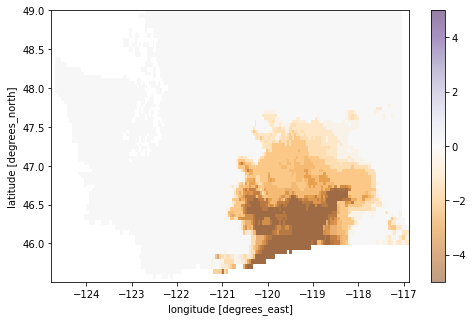

In [47]:
fig, ax = plt.subplots(figsize=(8,5))

(usdm_resample_sel.isel(date=0)-spi_usdmcat_sel.isel(day=0)).plot(ax=ax, vmin=-5, vmax=5, cmap='PuOr', alpha=0.5)
(usdm_resample_sel.isel(date=0)-spi_usdmcat_sel.isel(day=1)).plot(ax=ax, vmin=-5, vmax=5, cmap='PuOr', alpha=0.5, add_colorbar=False)

ax.set_title('')

In [48]:
spi_dates_df_filtered = spi_dates_df_filtered.reset_index()
spi_dates_df_filtered = spi_dates_df_filtered.drop(columns='index')
dates_2000 = spi_dates_df_filtered[spi_dates_df_filtered['USDM Date'] <= '2001']
dates_2000.head()

,SPI Date,DoW,Days Till Tuesday,Pull for USDM,USDM Date
0,1999-12-31,4,4,1.0,2000-01-04
1,2000-01-10,0,1,1.0,2000-01-11
2,2000-01-15,5,3,1.0,2000-01-18
3,2000-01-25,1,0,1.0,2000-01-25
4,2000-01-30,6,2,1.0,2000-02-01


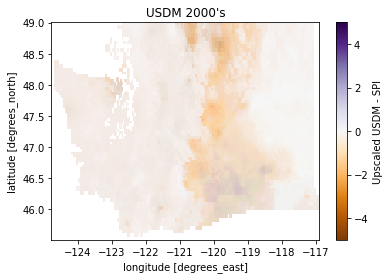

In [49]:
fig, ax = plt.subplots()

for i in dates_2000.index:
    (usdm_resample_sel.isel(date=i)-spi_usdmcat_sel.isel(day=i)).plot(ax=ax, vmin=-5, vmax=5, cmap='PuOr', alpha=1/len(dates_2000), add_colorbar=False)

ax.set_title("USDM 2000's")

norm = mpl.colors.Normalize(vmin=-5, vmax=5)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='PuOr'))
cbar.set_label('Upscaled USDM - SPI')

Well that's kind of interesting ... it's like water colors. Would probably be better to group by water year.

In [50]:
date_pairs = spi_dates_df_filtered[['SPI Date', 'USDM Date']].copy()
date_pairs

,SPI Date,USDM Date
0,1999-12-31,2000-01-04
1,2000-01-10,2000-01-11
2,2000-01-15,2000-01-18
3,2000-01-25,2000-01-25
4,2000-01-30,2000-02-01
...,...,...
1143,2021-11-26,2021-11-30
1144,2021-12-06,2021-12-07
1145,2021-12-11,2021-12-14
1146,2021-12-21,2021-12-21


In [51]:
date_pairs['USDM Hydrologic Year'] = (pd.DatetimeIndex(date_pairs['USDM Date']) + pd.DateOffset(months=3)).year
date_pairs

,SPI Date,USDM Date,USDM Hydrologic Year
0,1999-12-31,2000-01-04,2000
1,2000-01-10,2000-01-11,2000
2,2000-01-15,2000-01-18,2000
3,2000-01-25,2000-01-25,2000
4,2000-01-30,2000-02-01,2000
...,...,...,...
1143,2021-11-26,2021-11-30,2022
1144,2021-12-06,2021-12-07,2022
1145,2021-12-11,2021-12-14,2022
1146,2021-12-21,2021-12-21,2022


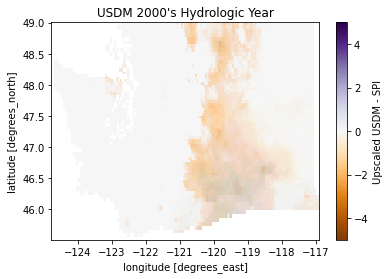

In [52]:
fig, ax = plt.subplots()


hyear_dates = date_pairs[date_pairs['USDM Hydrologic Year'] == pd.to_datetime('2000').year]
for i in hyear_dates.index:
    (usdm_resample_sel.isel(date=i)-spi_usdmcat_sel.isel(day=i)).plot(ax=ax, vmin=-5, vmax=5, cmap='PuOr', alpha=1/len(hyear_dates), add_colorbar=False)

ax.set_title("USDM 2000's Hydrologic Year")

norm = mpl.colors.Normalize(vmin=-5, vmax=5)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='PuOr'))
cbar.set_label('Upscaled USDM - SPI')

Let's try making a bunch of these ...

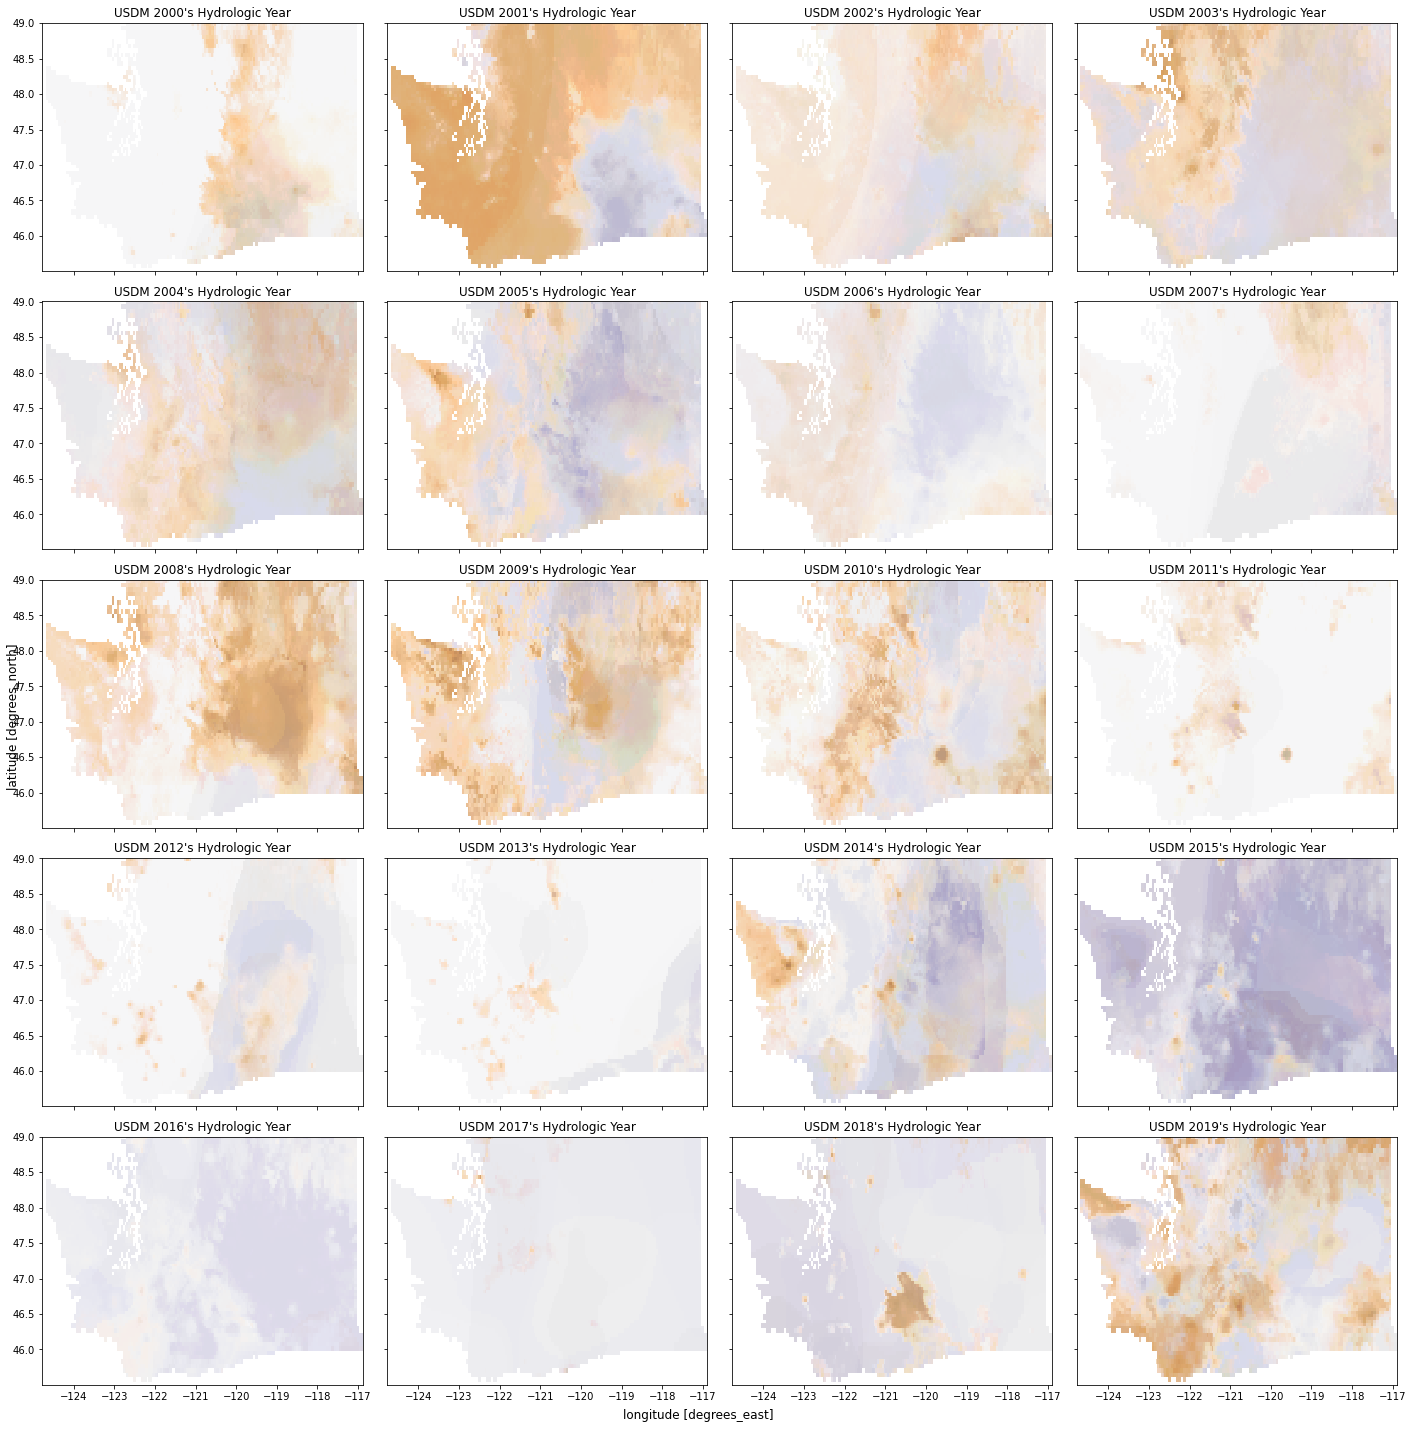

In [53]:
fig, axs = plt.subplots(5,4, figsize=(20, 20), sharex=True, sharey=True)

for year, ax in zip(np.arange(2000, 2021, 1), axs.ravel()):
    hyear_dates = date_pairs[date_pairs['USDM Hydrologic Year'] == pd.to_datetime(f'{year}').year]
    for i in hyear_dates.index:
        (usdm_resample_sel.isel(date=i)-spi_usdmcat_sel.isel(day=i)).plot(ax=ax, vmin=-5, vmax=5, cmap='PuOr', alpha=1/len(hyear_dates), add_colorbar=False)

    ax.set_title(f"USDM {year}'s Hydrologic Year")
    #ax.set_aspect('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.supylabel('latitude [degrees_north]')
fig.supxlabel('longitude [degrees_east]')

#norm = mpl.colors.Normalize(vmin=-5, vmax=5)
#cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='PuOr'))
#cbar.set_label('Upscaled USDM - SPI')

plt.tight_layout()

Instead, try out adding all the values and doing it that way ... see Friedrich's notebook https://github.com/adehecq/ragmac_xdem/blob/master/notebooks/temporal_fitting_analysis.ipynb

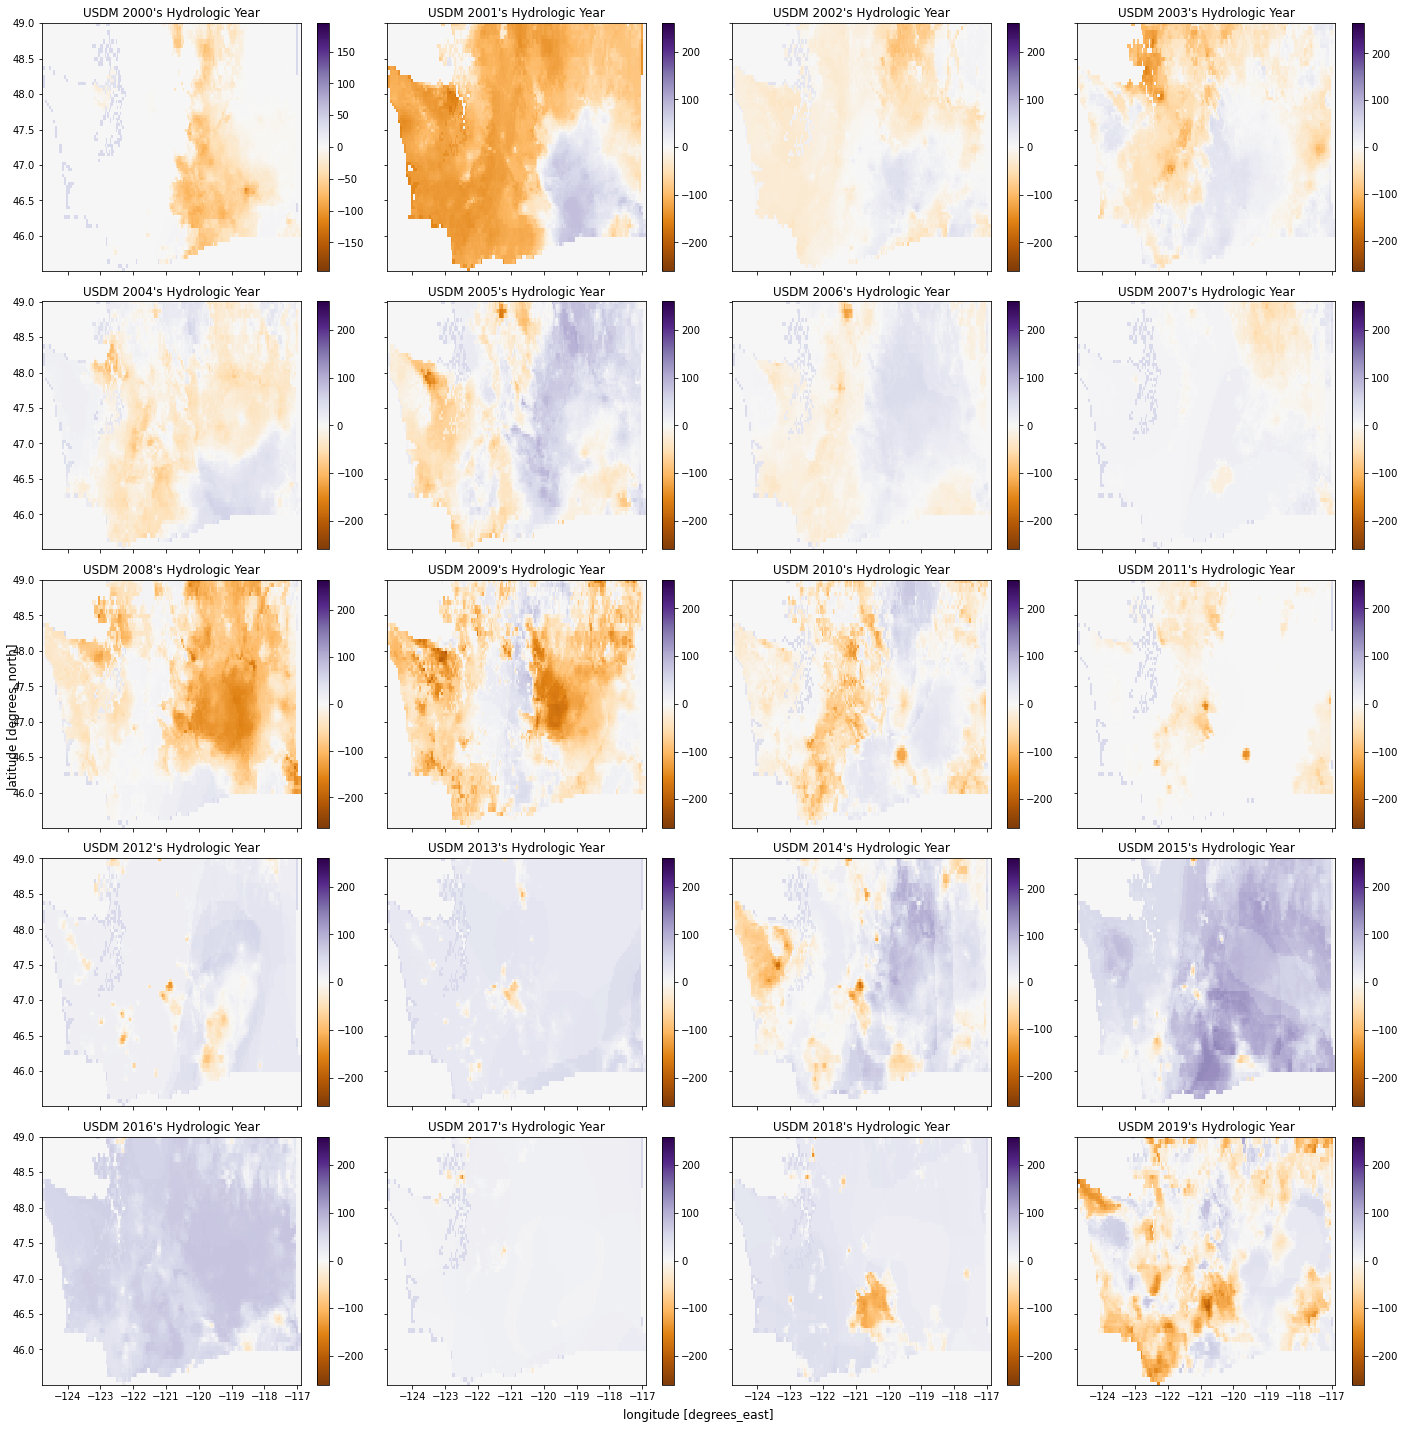

In [58]:
fig, axs = plt.subplots(5,4, figsize=(20, 20), sharex=True, sharey=True)

for year, ax in zip(np.arange(2000, 2021, 1), axs.ravel()):
    hyear_idxs = date_pairs[date_pairs['USDM Hydrologic Year'] == pd.to_datetime(f'{year}').year].index.values
    extreme = 5*len(hyear_idxs)
    (usdm_resample_sel.isel(date=hyear_idxs).sum(dim='date')-spi_usdmcat_sel.isel(day=hyear_idxs).sum(dim='day')).plot(ax=ax, vmin=-extreme, vmax=extreme, cmap='PuOr')

    ax.set_title(f"USDM {year}'s Hydrologic Year")
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.supylabel('latitude [degrees_north]')
fig.supxlabel('longitude [degrees_east]')

plt.tight_layout()